In [2]:
import pandas as pd
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# Question 1

### Load JSON Data

In [3]:
df_prompts = pd.read_csv("./DevGPT/snapshot_20230831/ChatGPT_Link_Sharing.csv") 

with open("./DevGPT/snapshot_20230831/20230831_061759_issue_sharings.json", "r", encoding="utf-8") as f:
    issue_data = json.load(f)

df_issues = pd.DataFrame(issue_data)

print(df_issues.head())

                                             Sources
0  {'Type': 'issue', 'URL': 'https://github.com/g...
1  {'Type': 'issue', 'URL': 'https://github.com/j...
2  {'Type': 'issue', 'URL': 'https://github.com/M...
3  {'Type': 'issue', 'URL': 'https://github.com/p...
4  {'Type': 'issue', 'URL': 'https://github.com/O...


The issue_data is a dictionary, but we expected foramt is a list of dictionaries.

In [4]:
if "Sources" in issue_data:  
    issue_list = issue_data["Sources"]

In [5]:
df_issues = pd.DataFrame(issue_list)
print(df_issues.head())  

    Type                                                URL         Author  \
0  issue  https://github.com/gakusyutai/gakusyutai.githu...         yuyu31   
1  issue  https://github.com/jabrena/aqa-tests-experimen...        jabrena   
2  issue  https://github.com/Matejkob/swift-syntax/issues/2       Matejkob   
3  issue  https://github.com/purpleslurple/PurpleSlurple...  purpleslurple   
4  issue  https://github.com/OpenVoiceOS/ovos-technical-...       JarbasAl   

                            RepoName RepoLanguage  Number  \
0    gakusyutai/gakusyutai.github.io         HTML      31   
1      jabrena/aqa-tests-experiments         Java       4   
2              Matejkob/swift-syntax        Swift       2   
3        purpleslurple/PurpleSlurple          PHP      63   
4  OpenVoiceOS/ovos-technical-manual         None       4   

                                 Title  \
0                        ハンバーガーメニューの実装   
1  Run a test in multiple java distros   
2                 LOTR Easter Egg Idea

### Preprocess Issue Descriptions

In this section, we will preprocesses text data from the "Body" column of df_issues (which contains GitHub issue descriptions). The preprocessing steps include:

1.	Lowercasing: Converts text to lowercase for uniformity.

2.	Removing Special Characters: Removes punctuation and non-word characters.

3.	Tokenization: Splits text into individual words.

4.	Lemmatization: Converts words to their base form (e.g., “running” → “run”).
	
5.	Stopword Removal: Removes common words like “the,” “and,” “is” that do not add meaningful context.

In [6]:
# Download necessary NLTK data
#nltk.download("stopwords")
#nltk.download("punkt")
#nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower() 
    text = re.sub(r'\W+', ' ', text) 
    tokens = word_tokenize(text)  
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  
    return " ".join(tokens)

df_issues["cleaned_text"] = df_issues["Body"].apply(lambda x: preprocess_text(x) if isinstance(x, str) else "")

### Classify Issues into Categories

We will classify developer queries into common categories:

##### **1. Bug Fixes**
- Developers ask for help debugging, fixing errors, and troubleshooting issues.

##### **2. Feature Requests**
- Developers seek help implementing new functionality or extending existing features.

##### **3. Theoretical Questions**
- Developers ask about programming concepts, best practices, or explanations.

##### **4. Performance Optimization**
- Developers seek help improving efficiency, speed, or scalability.

##### **5. Code Refactoring**
- Developers ask for improvements in code readability, maintainability, and best practices.

##### **6. Security Concerns**
- Developers seek guidance on fixing vulnerabilities and security flaws.

##### **7. General Programming Advice**
- General coding help, language syntax, API usage, and troubleshooting.

	

In [7]:
#Categoires created by ChatGPT
def classify_issue(text):
    text = str(text).lower()
    
    if any(word in text for word in ["error", "bug", "fix", "debug", "traceback", "exception", "crash", "failure"]):
        return "Bug Fix"
    elif any(word in text for word in ["feature", "request", "add", "enhancement", "improve", "support"]):
        return "Feature Request"
    elif any(word in text for word in ["explain", "concept", "difference", "theory", "how to", "what is"]):
        return "Theoretical Question"
    elif any(word in text for word in ["optimize", "efficiency", "performance", "slow", "scalability", "speed"]):
        return "Performance Optimization"
    elif any(word in text for word in ["refactor", "clean code", "improve readability", "best practice"]):
        return "Code Refactoring"
    elif any(word in text for word in ["security", "vulnerability", "exploit", "xss", "sql injection", "risk"]):
        return "Security Concern"
    else:
        return "General Programming Advice"

df_issues["Category"] = df_issues["cleaned_text"].apply(classify_issue)

### Analyzing Issue Distribution

General Programming Advice    189
Feature Request                75
Bug Fix                        73
Theoretical Question           11
Performance Optimization        5
Name: Category, dtype: int64


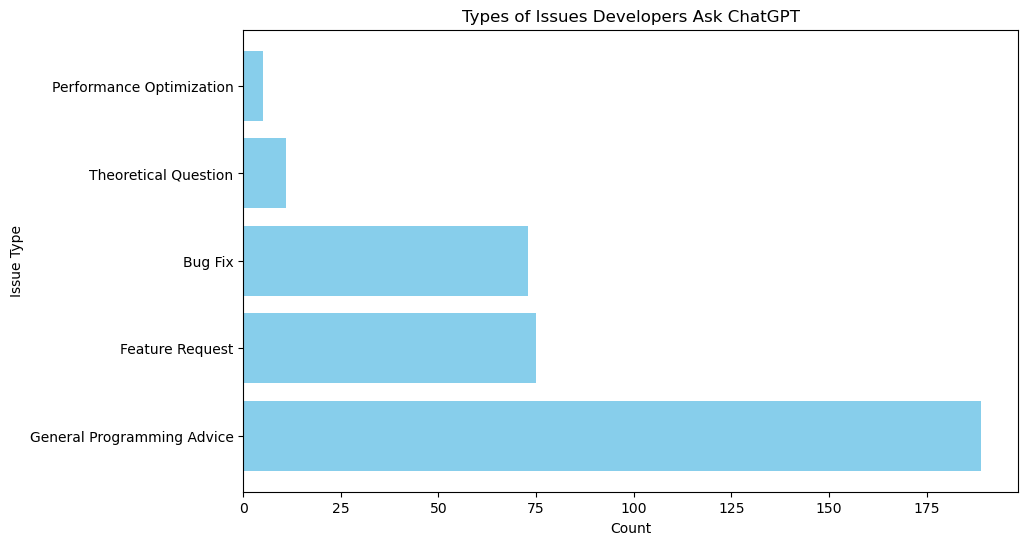

In [8]:
import matplotlib.pyplot as plt

category_counts = df_issues["Category"].value_counts()

print(category_counts)

plt.figure(figsize=(10, 6))  # Set figure size
plt.barh(category_counts.index, category_counts.values, color="skyblue")  # Horizontal bar chart

# Labels and title
plt.xlabel("Count")  # X-axis shows the count
plt.ylabel("Issue Type")  # Y-axis shows the issue categories
plt.title("Types of Issues Developers Ask ChatGPT")

# Show the plot
plt.show()

From the bar chart we can see:

General Programming Advice is the most common category.

Feature Requests and Bug Fixes have similar frequencies.

Theoretical Questions and Performance Optimization are the least common.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(df_issues["cleaned_text"])
y = df_issues["Category"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                            precision    recall  f1-score   support

                   Bug Fix       0.30      0.38      0.33         8
           Feature Request       0.75      0.27      0.40        11
General Programming Advice       0.77      0.92      0.84        48
  Performance Optimization       0.00      0.00      0.00         2
      Theoretical Question       0.00      0.00      0.00         2

                  accuracy                           0.70        71
                 macro avg       0.36      0.31      0.31        71
              weighted avg       0.67      0.70      0.67        71



/Applications/conda/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/conda/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/conda/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

/var/folders/90/q002cdps3sl4ccphgjsk64q80000gn/T/ipykernel_20954/173783793.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_trend = df_issues.groupby(df_issues["CreatedAt"].dt.to_period("M"))["Category"].value_counts().unstack()


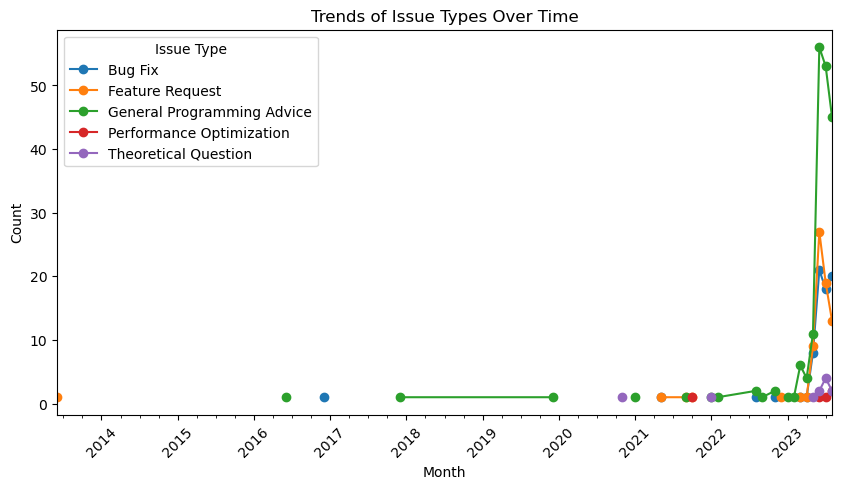

In [10]:
# Convert 'CreatedAt' column to datetime format (if available)
df_issues["CreatedAt"] = pd.to_datetime(df_issues["CreatedAt"], errors='coerce')

df_trend = df_issues.groupby(df_issues["CreatedAt"].dt.to_period("M"))["Category"].value_counts().unstack()

df_trend.plot(kind="line", figsize=(10, 5), marker="o")
plt.title("Trends of Issue Types Over Time")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(title="Issue Type")
plt.xticks(rotation=45)
plt.show()

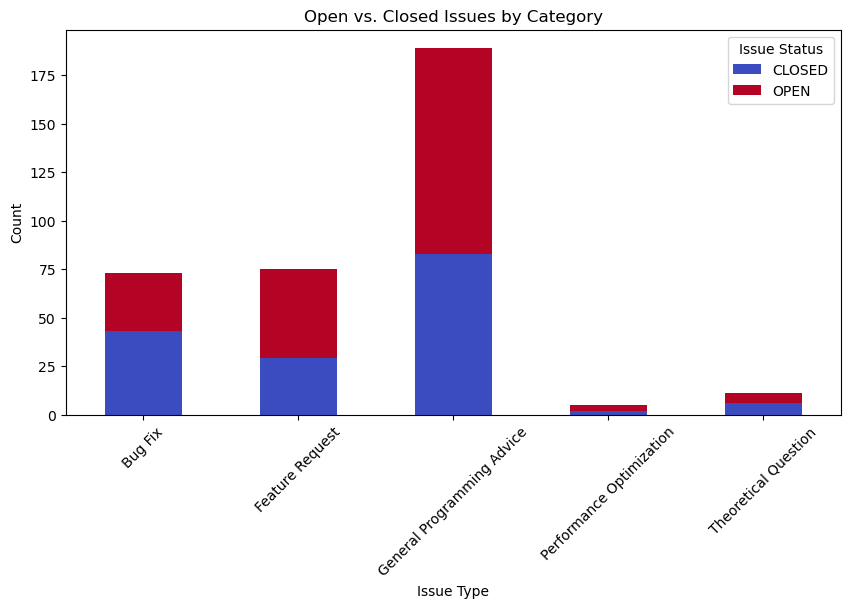

In [11]:
# Check open vs. closed issues
df_issues["State"] = df_issues["State"].fillna("UNKNOWN")  # Handle missing values
issue_status = df_issues.groupby("Category")["State"].value_counts().unstack()

# Plot the resolution rate
issue_status.plot(kind="bar", stacked=True, figsize=(10, 5), colormap="coolwarm")
plt.title("Open vs. Closed Issues by Category")
plt.xlabel("Issue Type")
plt.ylabel("Count")
plt.legend(title="Issue Status")
plt.xticks(rotation=45)
plt.show()

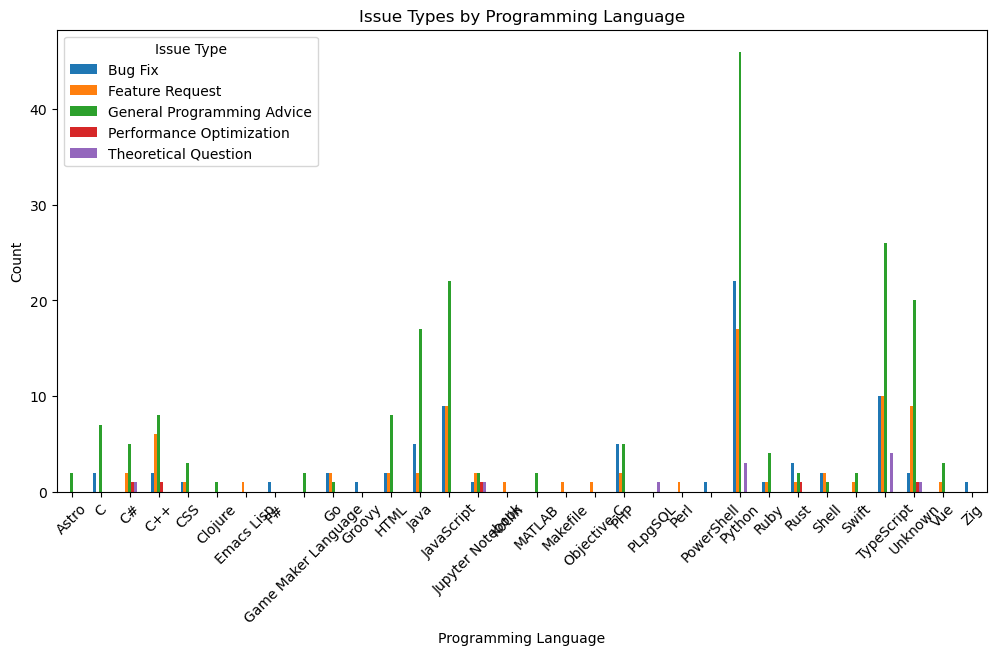

In [12]:

df_issues["RepoLanguage"].fillna("Unknown", inplace=True)
lang_counts = df_issues.groupby("RepoLanguage")["Category"].value_counts().unstack()

# Plot language-based issue types
lang_counts.plot(kind="bar", figsize=(12, 6))
plt.title("Issue Types by Programming Language")
plt.xlabel("Programming Language")
plt.ylabel("Count")
plt.legend(title="Issue Type")
plt.xticks(rotation=45)
plt.show()

# Question 2

In [13]:
df_prompts.head()

,URL,Status,MentionedURL,MentionedSource,MentionedProperty,MentionedAuthor
0,https://chat.openai.com/share/9fb7d601-2a86-40...,200,https://github.com/daeuniverse/dae-wing/pull/115,pull request,body,dae-bot
1,https://chat.openai.com/share/acece149-6d4b-45...,200,https://github.com/FlorianWoelki/obsidian-symb...,pull request,body,sharshuv-quotient
2,https://chat.openai.com/share/8bd33825-e8c6-44...,200,https://github.com/labdao/plex/pull/469,pull request,body,AdamGoyer
3,https://chat.openai.com/share/2c4b0dba-429c-4c...,200,https://github.com/labdao/plex/pull/468,pull request,body,AdamGoyer
4,https://chat.openai.com/share/a3f23f8c-935e-4b...,200,https://github.com/mlc-ai/web-stable-diffusion...,pull request,comments.body,jchris


### merge data 

In [14]:
df_merged = df_prompts.merge(df_issues, left_on="MentionedURL", right_on="URL", how="inner")
df_merged.head()


,URL_x,Status,MentionedURL,MentionedSource,MentionedProperty,MentionedAuthor,Type,URL_y,Author,RepoName,...,Number,Title,Body,CreatedAt,ClosedAt,UpdatedAt,State,ChatgptSharing,cleaned_text,Category
0,https://chat.openai.com/share/7958273c-0081-48...,200,https://github.com/gakusyutai/gakusyutai.githu...,issue,body,yuyu31,issue,https://github.com/gakusyutai/gakusyutai.githu...,yuyu31,gakusyutai/gakusyutai.github.io,...,31,ハンバーガーメニューの実装,- https://chat.openai.com/share/8b0f517f-1aaf-...,2023-07-23 15:38:42+00:00,None,2023-07-23T15:38:42Z,OPEN,[{'URL': 'https://chat.openai.com/share/795827...,http chat openai com share 8b0f517f 1aaf 4b50 ...,General Programming Advice
1,https://chat.openai.com/share/8b0f517f-1aaf-4b...,200,https://github.com/gakusyutai/gakusyutai.githu...,issue,body,yuyu31,issue,https://github.com/gakusyutai/gakusyutai.githu...,yuyu31,gakusyutai/gakusyutai.github.io,...,31,ハンバーガーメニューの実装,- https://chat.openai.com/share/8b0f517f-1aaf-...,2023-07-23 15:38:42+00:00,None,2023-07-23T15:38:42Z,OPEN,[{'URL': 'https://chat.openai.com/share/795827...,http chat openai com share 8b0f517f 1aaf 4b50 ...,General Programming Advice
2,https://chat.openai.com/share/e169e9a7-40c5-46...,200,https://github.com/jabrena/aqa-tests-experimen...,issue,body,jabrena,issue,https://github.com/jabrena/aqa-tests-experimen...,jabrena,jabrena/aqa-tests-experiments,...,4,Run a test in multiple java distros,- https://chat.openai.com/share/e169e9a7-40c5-...,2023-07-07 20:30:07+00:00,None,2023-07-08T11:56:45Z,OPEN,[{'URL': 'https://chat.openai.com/share/e169e9...,http chat openai com share e169e9a7 40c5 46ab ...,General Programming Advice
3,https://chat.openai.com/share/b508ddd3-af83-42...,200,https://github.com/jabrena/aqa-tests-experimen...,issue,body,jabrena,issue,https://github.com/jabrena/aqa-tests-experimen...,jabrena,jabrena/aqa-tests-experiments,...,4,Run a test in multiple java distros,- https://chat.openai.com/share/e169e9a7-40c5-...,2023-07-07 20:30:07+00:00,None,2023-07-08T11:56:45Z,OPEN,[{'URL': 'https://chat.openai.com/share/e169e9...,http chat openai com share e169e9a7 40c5 46ab ...,General Programming Advice
4,https://chat.openai.com/share/340a3228-4be2-4f...,200,https://github.com/Matejkob/swift-syntax/issues/2,issue,body,Matejkob,issue,https://github.com/Matejkob/swift-syntax/issues/2,Matejkob,Matejkob/swift-syntax,...,2,LOTR Easter Egg Idea,https://chat.openai.com/share/340a3228-4be2-4f...,2023-08-26 08:16:53+00:00,None,2023-08-26T08:16:53Z,OPEN,[{'URL': 'https://chat.openai.com/share/340a32...,http chat openai com share 340a3228 4be2 4f9c ...,General Programming Advice


In [15]:
df_merged["Category"] = df_issues["cleaned_text"].apply(classify_issue)

Next step, we will Convert issue state to binary (1 = Resolved, 0 = Unresolved), and then Calculate resolution rates.

In [16]:
df_merged["Resolved"] = df_merged["State"].apply(lambda x: 1 if x == "CLOSED" else 0)
resolution_rates = df_merged.groupby("Category")["Resolved"].mean()

print(resolution_rates)

Category
Bug Fix                       0.562500
Feature Request               0.500000
General Programming Advice    0.359223
Performance Optimization      1.000000
Theoretical Question          0.500000
Name: Resolved, dtype: float64


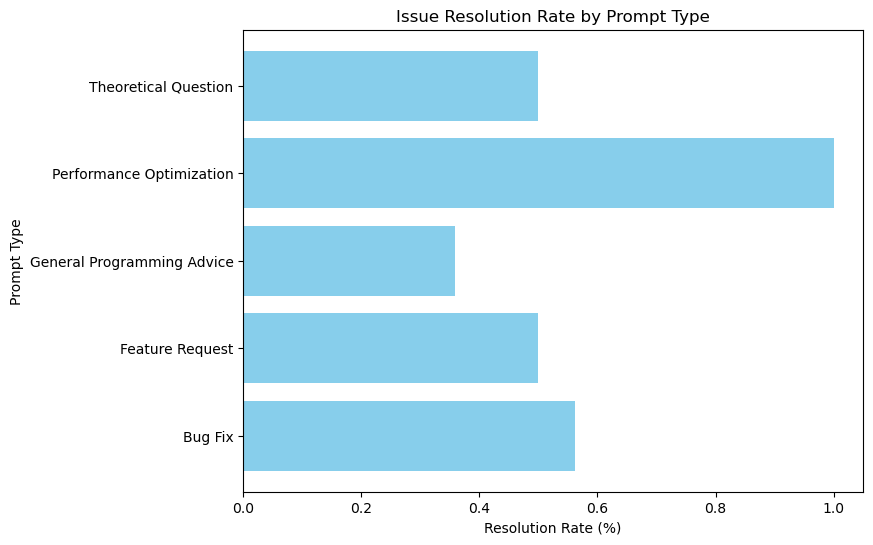

In [18]:
import matplotlib.pyplot as plt

# Create a horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(resolution_rates.index, resolution_rates.values, color="skyblue")

# Labels and title
plt.xlabel("Resolution Rate (%)")  # X-axis shows resolution rate
plt.ylabel("Prompt Type")  # Y-axis shows prompt types
plt.title("Issue Resolution Rate by Prompt Type")

# Show the chart
plt.show()